# PL ANALYSIS
* Hi! This notebook is for analysis of EL data. 
* I am assuming your data is organised in this format: [Path to all the data]\\[name of sample]\\[Pixel number]. 
    * These will have a bunch of images, a folder called 'refs', a folder called 'white'and a csv file called IV
    
### Some instructions: 
* Please run each cell in order, following the instructions
* Have at hand your datapath, and the path you would like to save the data in
    * The outputs will sometimes show here but all of it is saved in the folder you provide
* Press cntrl+enter to run a cell
* When prompted enter information into the feilds and press enter
* If you go back and re run a cell, that's fine but you have to run every cell after that again, and in order

This might break if all these files are not there! If you want to edit this code definately go ahead, a bunch of the functions live in seperate .py files, BUT please make a copy!!!

SEE LAST PANEL FOR BASIC HELP IF YOU HAVE DIFFICULTY

In [1]:
# Some imports:
from external_imports import *
from image_process import *
from general_data_process import *
from reconstruct_jv import *
from joblib import Parallel, delayed
import multiprocessing

### Data + Save folders
* Copy and paste the path to your data bellow, as well as where you would like the output files from this analysis to be saved
* Don't remove the " " marks, or the 'r' in front of them, that's important!
* Again, make sure your data is organised in the "[Path to all the data]\[name of sample]\[Pixel number]" format

In [2]:
datapath = r"C:\Users\akashdasgupta\Desktop\actual_but_reduced"
savepath = r"C:\Users\akashdasgupta\Desktop\analysis"

path_db = path_process(datapath)

### STEP 3: Enter bandgaps
* We need bandgaps for the calculations
* Run bellow, enter as it prompts 

In [93]:
bandgaps = {}
for key in path_db.keys():
    if key.lower() != 'white':
        string = "What's the bandgap of "+key+" in eV?: "
        bandgap = float(input(string))
        bandgaps[key] = bandgap

What's the bandgap of 3800DB in eV?: 1.8
What's the bandgap of 3800DC in eV?: 1.8
What's the bandgap of ALD3 in eV?: 1.25
What's the bandgap of BCP3 in eV?: 1.25


### STEP 5: Calculate corrections

In [94]:
with open(f"{datapath}\\white_params.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0].lower() == "exposure":
            white_exposure = float(row[1])
        elif row[0].lower() == "flux scale":
            white_flux = float(row[1])
        
correction_db = {}
for key in path_db.keys(): 
    bandgap = bandgaps[key]
    correction = white_over_cell_correction(white_exposure, ledspecf, np.vectorize(BBf_cellf), 
                                            bandgap, camqef, lenscalf, 0.99, filtcalf)

    correction_db[key] = correction

C:\Users\akashdasgupta\Scripts\el_analysis\reconstruct_jv.py:44: RuntimeWarning: invalid value encountered in log
  Vs =  voc_rads +  (sci.k*298/sci.e)*np.log(rrs)


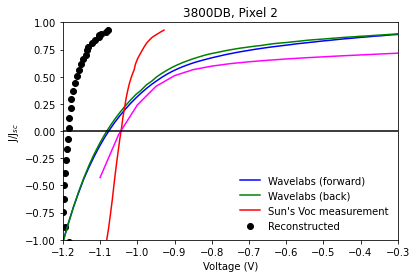

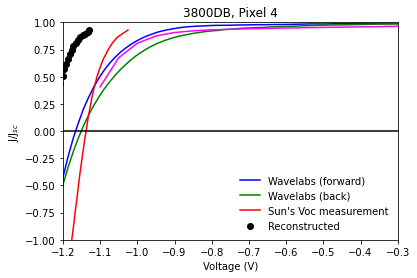

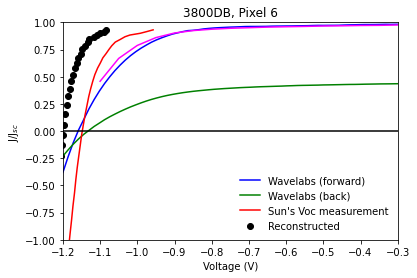

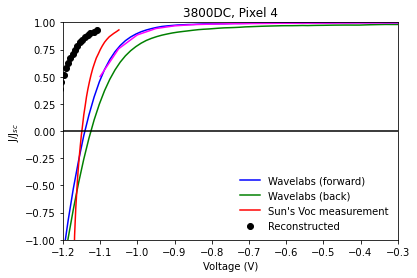

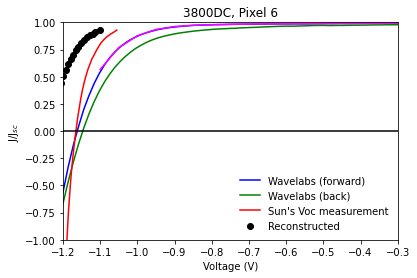

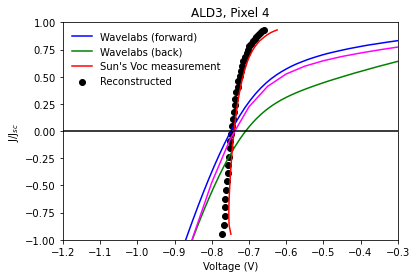

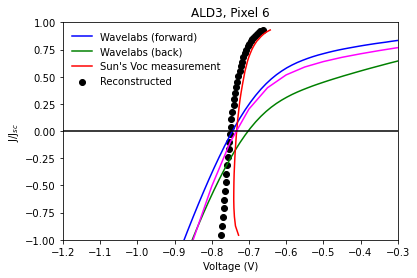

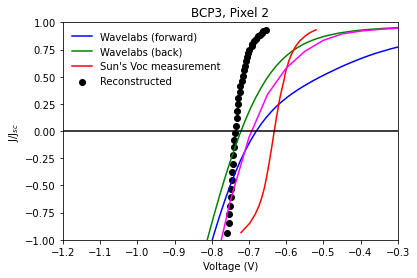

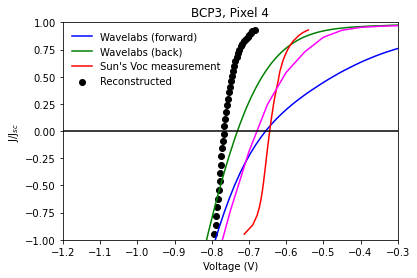

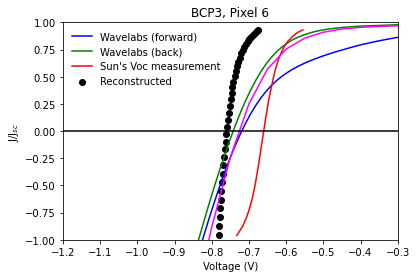

In [97]:
solar_sim_path  = r"C:\Users\akashdasgupta\Desktop\Real_stuff\jv_before_after"

for key in path_db.keys():
    for pix in path_db[key]:     

        path = f"{datapath}\\{key}\\{pix}"

        bandgap = bandgaps[key]

        white_mean_scaled = np.mean(np.load(f"{datapath}\\{key}\\{pix}\\white.npy"))/(correction_db[key]*white_flux)
        flux_1sun = j1sunf(bandgap)
        voc_rad = vocradf(bandgap)
        row, col = np.load(f"{datapath}\\{key}\\{pix}\\{find_npy(path)[0]}").shape

        num_suns, rrs, Vs, Js, fluxes = single_pixel_jv(path, row, col, flux_1sun, voc_rad, white_mean_scaled)

        
        ##########
        # Suns voc plot
        suns_voc_V = []
        with open(f"{datapath}\\{key}\\{pix}\\oc\\source_meter.csv",'r') as file:
            reader = csv.reader(file)
            for row in reader:
                suns_voc_V.append(float(row[0]))
        suns_voc_V = np.array(suns_voc_V)
        num_suns_suns_voc = deepcopy(num_suns)
        num_suns_suns_voc.sort()
        num_suns_suns_voc = np.flip(num_suns_suns_voc)
        

        #########
        # Solar sim plot:
        
        filebf = f"{solar_sim_path}\\before\\{key}_{pix}_f.tsv"
        filebb = f"{solar_sim_path}\\before\\{key}_{pix}_b.tsv"
        
        bf_v, bf_i = open_wavelabs_data(filebf)
        bb_v, bb_i = open_wavelabs_data(filebb)
        
        ########
        # vsweep
        vsweep_v = []
        vsweep_i = []
        with open(f"{datapath}\\{key}\\{pix}\\vsweep\\source_meter.csv",'r') as file:
            reader = csv.reader(file)
            for row in reader:
                vsweep_v.append(float(row[0]))
                vsweep_i.append(float(row[1]))
        vsweep_v = np.array(vsweep_v)
        vsweep_i = np.array(vsweep_i)/np.max(vsweep_i)
        #####
        # Plot
        
        plt.scatter(-Vs, Js, color='k', label = 'Reconstructed')
        plt.plot(bf_v,bf_i/bf_i[np.argmax(bf_v)], color='b', label='Wavelabs (forward)')
        plt.plot(bb_v,bb_i/bb_i[np.argmax(bb_v)], color='g', label='Wavelabs (back)')
        plt.plot(suns_voc_V, 1-num_suns_suns_voc, color='r', label = "Sun's Voc measurement")
        plt.plot(vsweep_v,vsweep_i, color='magenta')
        
        plt.xlim((-1.2,-0.3))      
        plt.ylim((-1,1))
        plt.axhline(0,color='k')
        
        plt.legend(frameon=False)
        plt.xlabel("Voltage (V)")
        plt.ylabel("J/J$_{sc}$")
        plt.title(f"{key}, Pixel {pix}")
        plt.show()

In [46]:
print(suns_voc_V)

[-0.732468 -0.716698 -0.706104 -0.698225 -0.691975 -0.686656 -0.682247
 -0.678309 -0.674512 -0.671175 -0.667794 -0.664703 -0.661736 -0.658558
 -0.65568  -0.652393 -0.649423 -0.646458 -0.642965 -0.639771 -0.636491
 -0.633318 -0.630094 -0.626245 -0.62255  -0.618752 -0.61409  -0.609905
 -0.604759 -0.600055 -0.595039 -0.588913 -0.583317 -0.577388 -0.570135
 -0.563398 -0.555208]


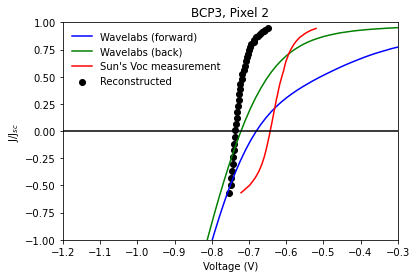

In [96]:
key = "BCP3"
pix= 2

path = f"{datapath}\\{key}\\{pix}"

bandgap = bandgaps[key]

white_mean_scaled = np.mean(np.load(f"{datapath}\\{key}\\{pix}\\white.npy"))/(correction_db[key]*white_flux)
flux_1sun = j1sunf(bandgap)
voc_rad = vocradf(bandgap)
row, col = np.load(f"{datapath}\\{key}\\{pix}\\{find_npy(path)[0]}").shape

num_suns, rrs, Vs, Js, fluxes = single_pixel_jv(path, row, col,  2.578894727258342e+17, voc_rad, white_mean_scaled)


##########
# Suns voc plot
suns_voc_V = []
with open(f"{datapath}\\{key}\\{pix}\\oc\\source_meter.csv",'r') as file:
    reader = csv.reader(file)
    for row in reader:
        suns_voc_V.append(float(row[0]))
suns_voc_V = np.array(suns_voc_V)
num_suns_suns_voc = deepcopy(num_suns)
num_suns_suns_voc.sort()
num_suns_suns_voc = np.flip(num_suns_suns_voc)


#########
# Solar sim plot:

filebf = f"{solar_sim_path}\\before\\{key}_{pix}_f.tsv"
filebb = f"{solar_sim_path}\\before\\{key}_{pix}_b.tsv"

bf_v, bf_i = open_wavelabs_data(filebf)
bb_v, bb_i = open_wavelabs_data(filebb)

# vsweep
vsweep_v = []
vsweep_i = []
with open(f"{datapath}\\{key}\\{pix}\\vsweep\\source_meter.csv",'r') as file:
    reader = csv.reader(file)
    for row in reader:
        vsweep_v.append(float(row[0]))
        vsweep_i.append(float(row[1]))
vsweep_v = np.array(vsweep_v)
vsweep_i = np.array(vsweep_i)/np.max(vsweep_i)

#####
# Plot

plt.scatter(-Vs, Js, color='k', label = 'Reconstructed')
plt.plot(bf_v,bf_i/bf_i[np.argmax(bf_v)], color='b', label='Wavelabs (forward)')
plt.plot(bb_v,bb_i/bb_i[np.argmax(bb_v)], color='g', label='Wavelabs (back)')
plt.plot(suns_voc_V, 1-num_suns_suns_voc, color='r', label = "Sun's Voc measurement")


plt.xlim((-1.2,-0.3))      
plt.ylim((-1,1))
plt.axhline(0,color='k')

plt.legend(frameon=False)
plt.xlabel("Voltage (V)")
plt.ylabel("J/J$_{sc}$")
plt.title(f"{key}, Pixel {pix}")
plt.show()

In [68]:
flux_1sun # 2.578894727258342e+17

2.0906739336365286e+17

In [90]:
correction_db

{'3800DB': 0.007446838924548506,
 '3800DC': 0.00800952999583925,
 'ALD3': 0.043212750296387416,
 'BCP3': 0.007212457847935057}